In [1]:
%matplotlib inline
%load_ext lab_black
import os
from dcec.utils import input_shape, input_shape1d, input_shape_dense
from dcec.model import CAE, CAE1d, dense

list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
nb_features = len(list_features)
nb_samples = 64
flow = "162-216"
runway = "14"

data_dir = "./data"
res_dir = "./res"

files = ["lszh"]  # , f"lszh_{runway}"]  # , f"lszh_{flow}_{runway}"]
lambda_kls = [0.07]  # [0, 0.07 , 0.5]

refresh_figs = True

# CAE2D
# sel_input_shape, sel_cae = input_shape, CAE

# CAE1D
# sel_input_shape, sel_cae = input_shape1d, CAE1d

# dense
sel_input_shape, sel_cae = input_shape_dense, dense


def param(p):
    return str(p).replace(".", "_")

/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pkg_resources/__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/ipyleaflet/leaflet.py:317: DeprecationWarning: metadata {'dtype': None} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  data = Dataset().tag(dtype=None, sync=True, to_json=ds_x_to_json)
Using TensorFlow backend.
/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [2]:
# Generating data
if not os.path.exists(f"{data_dir}_{nb_samples}"):
    from traffic.data.datasets import landing_zurich_2019 as t

    os.makedirs(f"{data_dir}_{nb_samples}")

    path = f"{data_dir}_{nb_samples}/lszh.parquet"
    if not os.path.exists(path):
        print(f"Generating data for full traffic...")
        t_r = (
            t.query("track == track")
            .resample(nb_samples)
            .unwrap("track")
            .eval(max_workers=10)
        )
        t_r.to_parquet(path)

    path = f"{data_dir}_{nb_samples}/lszh_{runway}.parquet"
    if not os.path.exists(path):
        print(f"Generating data for {flow} and {runway}...")
        t_r = (
            t.query(f"track == track and runway =='{runway}'")
            .resample(nb_samples)
            .unwrap("track")
            .eval(max_workers=10)
        )
        t_r.to_parquet(path)

    path = f"{data_dir}_{nb_samples}/lszh_{flow}_{runway}.parquet"
    if not os.path.exists(path):
        print(f"Generating data for {flow} and {runway}...")
        t_r = (
            t.query(
                f"track == track and initial_flow == '{flow}' and runway =='{runway}'"
            )
            .resample(nb_samples)
            .unwrap("track")
            .eval(max_workers=10)
        )
        t_r.to_parquet(path)

In [3]:
# ARTEFACT clustering
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from traffic.core import Traffic
from artefact import AutoencoderTSNE, Autoencoder
from artefact.clustering import get_latent
from artefact.plot import plot_latent_and_trajs


def artefact_clustering(file, lambda_kl):
    if not os.path.exists(f"{res_dir}_{nb_samples}"):
        os.makedirs(f"{res_dir}_{nb_samples}")

    path = f"{res_dir}_{nb_samples}/{file}_artefact_{param(lambda_kl)}"
    if not os.path.exists(f"{path}.parquet"):
        print(f"Training autoencoder with data {file} and lambda_kl {lambda_kl}...")
        t = Traffic.from_file(f"{data_dir}_{nb_samples}/{file}.parquet")
        model = Autoencoder((nb_samples * nb_features, 32, 8, 2))
        ae_tsne = AutoencoderTSNE(
            gpu=0,
            batch_size=1000 if lambda_kl > 0 else len(t),
            model=model,
            lambda_kl=lambda_kl,
            nb_iterations=800 if lambda_kl > 0 else 5000,
            algo_clustering=GaussianMixture(n_components=5 if file == "lszh" else 4),
            distance_trajectory="euclidean",  # delta_max
            savepath=f"{path}.pth",
        )
        t_c = t.clustering(
            nb_samples=None,  # nb_samples,
            features=list_features,
            clustering=ae_tsne,
            transform=MinMaxScaler(feature_range=(-1, 1)),
            max_workers=10,
        ).fit_predict()
        t_c.to_parquet(f"{path}.parquet")
        #         np.save(
        #             f"{path}_x.npy", ae_tsne.X,
        #         )
        np.savez(
            f"{path}_loss",
            loss=np.asarray(ae_tsne.loss["loss"]),
            re_loss=np.asarray(ae_tsne.loss["re_loss"]),
            kl_loss=np.asarray(ae_tsne.loss["kl_loss"]),
        )
        np.save(f"{path}_lat.npy", ae_tsne.get_latent())
        re, scores = ae_tsne.score_samples()
        np.savez(f"{path}_scores", re, scores)


for file in files:
    for lambda_kl in lambda_kls:
        artefact_clustering(file, lambda_kl)

In [4]:
# DCEC clustering
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from traffic.core import Traffic
from dcec.clustering import DCEC
from dcec.utils import input_shape, input_shape1d


def dcec_clustering(file, lambda_kl):
    if not os.path.exists(f"{res_dir}_{nb_samples}"):
        os.makedirs(f"{res_dir}_{nb_samples}")

    path = f"{res_dir}_{nb_samples}/{file}_dcec_{param(lambda_kl)}"
    # if os.path.exists(f"{path}.parquet"):
    #        return

    print(f"Training dcec with data {file} and lambda_kl {lambda_kl}...")
    t = Traffic.from_file(f"{data_dir}_{nb_samples}/{file}.parquet")

    dcec = DCEC(
        input_shape=sel_input_shape(nb_samples, nb_features),
        filters=[32, 64, 2],
        n_clusters=5 if file == "lszh" else 4,
        cae=sel_cae,
        lambda_kl=lambda_kl,
        batch_size=1000,
        epochs=1000,
        maxiter=10000,
        update_interval=140,
        save_dir=path,
    )

    t_c = t.clustering(
        nb_samples=None,
        features=list_features,
        clustering=dcec,
        transform=MinMaxScaler(feature_range=(-1, 1)),
    ).fit_predict()

    t_c.to_parquet(f"{path}.parquet")
    loss_evolution = np.asarray(dcec.loss_evolution).T
    np.savez(
        f"{path}_loss",
        loss=loss_evolution[0],
        kl_loss=loss_evolution[1],
        re_loss=loss_evolution[2],
    )
    # np.save(f"{path}_x.npy", dcec.X)
    np.save(f"{path}_lat.npy", dcec.extract_feature(dcec.X))
    re, scores = dcec.score_samples(dcec.X)
    np.savez(f"{path}_scores", re, scores)


for file in files:
    for lambda_kl in lambda_kls:
        dcec_clustering(file, lambda_kl)

Training dcec with data lszh and lambda_kl 0.07...


/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/pyarrow/pandas_compat.py:294: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance(name, collections.Sequence):


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
embedding (Dense)            (None, 2)                 66        
_________________________________________________________________
dense_4 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

/home/richard/anaconda3/envs/artefact/lib/python3.7/site-packages/keras/engine/training_utils.py:811: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(loss, collections.Mapping):


Pretraining time:  235.07399916648865
Pretrained weights are saved to ./res_64/lszh_dcec_0_07/pretrain_cae_model.h5
Initializing cluster centers with k-means.
saving model to: ./res_64/lszh_dcec_0_07/dcec_model_0.h5
saving model to: ./res_64/lszh_dcec_0_07/dcec_model_final.h5
Pretrain time:   235.13545036315918
Clustering time: 464.91361236572266
Total time:      700.0490627288818
self.X.shape (19457, 256)
y.shape (19457, 256)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
embedding (Dense)            (None, 2)                 66        
_________________________________________________________________
dense_11 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 128)              

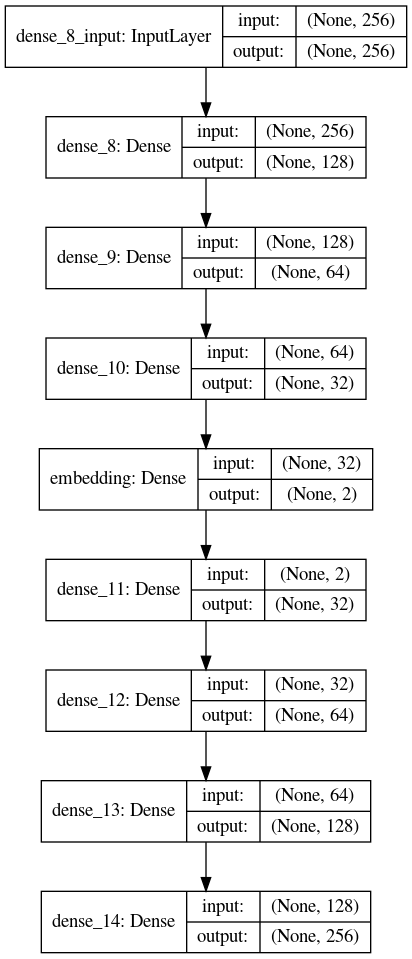

In [5]:
from keras.utils.vis_utils import plot_model

model = sel_cae(
    input_shape=sel_input_shape(nb_samples, nb_features), filters=[32, 64, 2]
)
plot_model(model, to_file=f"{res_dir}_{nb_samples}/cae.png", show_shapes=True)

0.005383455 0.002448678 0.030357953


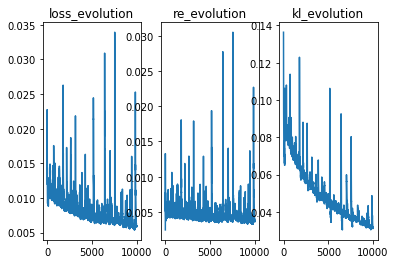

In [6]:
import numpy as np
from artefact.plot import plot_loss


def plot_losses(method, file, lambda_kl):
    path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}_loss"
    if not os.path.exists(f"{path}.npz") or refresh_figs:
        loss = np.load(f"{path}.npz")
        print(np.min(loss["loss"]), np.min(loss["re_loss"]), np.min(loss["kl_loss"]))
        plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"], f"{path}.png")


for file in files:
    for lambda_kl in lambda_kls:
        plot_losses("dcec", file, lambda_kl)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from traffic.core import Traffic


def plot_lats(method, file, lambda_kls, gb="cluster"):
    fig_path = f"{res_dir}_{nb_samples}/{file}_{method}_lat_{gb}.png"
    if os.path.exists(fig_path) and not refresh_figs:
        return
    colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ]
    with plt.style.context("traffic"):
        fig, axs = plt.subplots(
            1, len(lambda_kls), figsize=(15, 7.5), sharex=True, sharey=True
        )
        fig.text(
            0.5,
            0.04,
            "1st component on latent space",
            ha="center",
            va="center",
            fontsize=15,
        )
        fig.text(
            0.06,
            0.5,
            "2nd component on latent space",
            ha="center",
            va="center",
            rotation="vertical",
            fontsize=15,
        )
        for lambda_kl, ax in zip(lambda_kls, axs.reshape(-1)):
            path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}"
            t = Traffic.from_file(f"{path}.parquet")
            lat = np.load(f"{path}_lat.npy")
            subset = t.query("initial_flow != 'N/A'")
            df = pd.DataFrame.from_records(
                [
                    {"flight_id": id_, "x": x, "y": y}
                    for (id_, x, y) in zip(
                        list(f.flight_id for f in t), lat[:, 0], lat[:, 1]
                    )
                ]
            )
            df = df.assign(
                x=lambda df: (df.x - df.x.min()) / (df.x.max() - df.x.min()),
                y=lambda df: (df.y - df.y.min()) / (df.y.max() - df.y.min()),
            )
            cols = ["flight_id", gb]
            stasts = df.merge(subset.data[cols].drop_duplicates())
            for (flow, d), color in zip(stasts.groupby(gb), colors):
                d.plot.scatter(x="x", y="y", ax=ax, color=color, label=flow, alpha=0.4)

            ax.set_title(f"{file} - {lambda_kl}", fontsize=20, fontname="Ubuntu")
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.legend(prop=dict(family="Ubuntu", size=18))
            ax.grid(linestyle="solid", alpha=0.5, zorder=-2)
        print(fig_path)
        fig.savefig(fig_path)

In [8]:
for method in ["artefact", "dcec"]:
    for file in files:
        plot_lats(method, file, lambda_kls[1:3], gb="initial_flow")

./res_64/lszh_artefact_lat_initial_flow.png
./res_64/lszh_dcec_lat_initial_flow.png


<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

AttributeError: 'AxesSubplot' object has no attribute 'reshape'

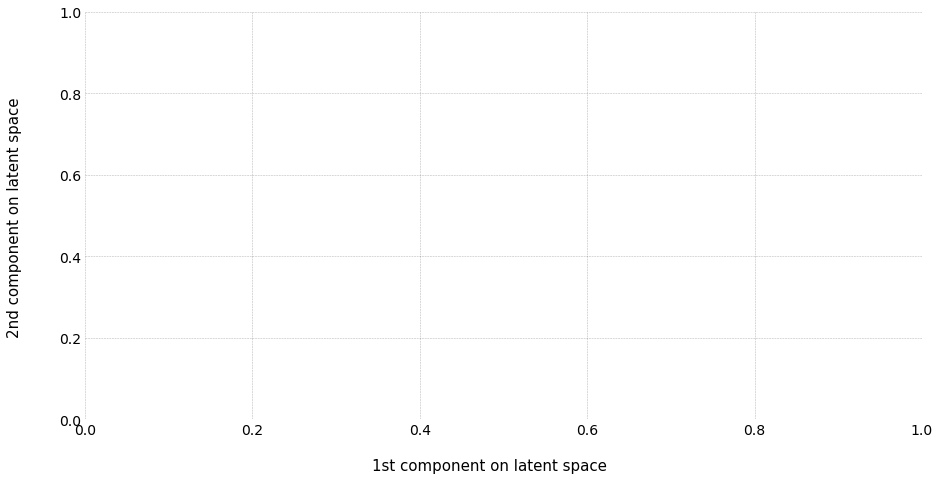

In [9]:
for i in range(2):
    plot_lats("artefact", files[i], lambda_kls, gb="cluster")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from traffic.core import Traffic
from traffic.data import airports
from traffic.drawing import EuroPP, PlateCarree, countries, rivers
from traffic.drawing.markers import atc_tower


def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [
        (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    ]
    ax.legend(*zip(*unique), prop=dict(family="Ubuntu", size=18))
    # ax.legend(*zip(*unique))


def plot_trajs(method, file, lambda_kls, gb="cluster"):
    fig_path = f"{res_dir}_{nb_samples}/{file}_{method}_trajs_{gb}.png"
    if os.path.exists(fig_path) and not refresh_figs:
        return

    with plt.style.context("traffic"):
        text_style = dict(
            verticalalignment="top",
            horizontalalignment="right",
            fontname="Ubuntu",
            fontsize=18,
            bbox=dict(facecolor="white", alpha=0.6, boxstyle="round"),
        )
        colors = [
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
            "#9467bd",
            "#8c564b",
            "#e377c2",
            "#7f7f7f",
            "#bcbd22",
            "#17becf",
        ]
        fig, axs = plt.subplots(
            1,
            len(lambda_kls),
            figsize=(15, 7.5),
            # sharex=True,
            # sharey=True,
            subplot_kw=dict(projection=EuroPP()),
        )
        extent = None
        for lambda_kl, ax in zip(lambda_kls, axs.reshape(-1)):
            ax.add_feature(
                countries(
                    edgecolor="white",
                    facecolor="#d9dadb",
                    alpha=1,
                    linewidth=2,
                    zorder=-2,
                )
            )
            ax.outline_patch.set_visible(False)
            ax.background_patch.set_visible(False)
            airports["LSZH"].point.plot(
                ax,
                shift=dict(units="dots", x=-15, y=-15),
                marker=atc_tower,
                s=300,
                zorder=5,
                text_kw={**text_style},
            )
            path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}"
            t = Traffic.from_file(f"{path}.parquet")
            subset = t.query("initial_flow != 'N/A'")
            for (flow, d), color in zip(subset.groupby(gb), colors):
                subset.query(f'{gb} == "{flow}"')[:50].plot(
                    ax, color=color, linewidth=1.5, alpha=0.5, label=flow
                )
            if extent is None:
                extent = ax.get_extent(PlateCarree())
            ax.set_extent(extent)
            ax.set_title(f"{file} - {lambda_kl}", fontsize=20, fontname="Ubuntu")
            legend_without_duplicate_labels(ax)
            ax.grid(linestyle="solid", alpha=0.5, zorder=-2)

        fig.savefig(fig_path)

In [ ]:
for i in range(2):
    plot_trajs("artefact", files[i], lambda_kls[:2])

In [ ]:
import numpy as np
from artefact.plot import plot_latent_and_trajs


def plot_lat_trajs(method, file, lambda_kl):
    path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}"
    if not os.path.exists(f"{path}_lat_trajs.png") or refresh_figs:
        t = Traffic.from_file(f"{path}.parquet")
        lat = np.load(f"{path}_lat.npy")
        plot_latent_and_trajs(t, lat, f"{path}_lat_trajs.png", runway=None)

In [ ]:
path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}"
method, files[1], lambda_kls[0]

In [ ]:
for method in ["artefact", "dcec"]:
    plot_lat_trajs(method, files[1], lambda_kls[0])

In [ ]:
for i in range(2):
    plot_lats("dcec", files[i], lambda_kls)

In [ ]:
for i in range(2):
    plot_trajs("dcec", files[i], lambda_kls[:2])

In [ ]:
import pandas as pd


def compute_scores(method, file, lambda_kl):
    path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}"
    t = Traffic.from_file(f"{path}.parquet")

    scores_path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}_scores"
    re, scores = None, None
    npzfile = np.load(f"{scores_path}.npz")
    re, scores = npzfile["arr_0"], npzfile["arr_1"]

    t_re = pd.DataFrame.from_records(
        [dict(flight_id=f.flight_id, re=re) for f, re in zip(t, re)]
    )
    t = t.merge(t_re, on="flight_id")
    d = {"flight_id": "nunique", "re": ["mean", "min", "max"]}

    t_scores = pd.DataFrame.from_records(
        [dict(flight_id=f.flight_id, score=score) for f, score in zip(t, scores)]
    )
    t = t.merge(t_scores, on="flight_id")
    d["score"] = ["mean", "min", "max"]

    return t


def generate_score_table(method):
    for file in files:
        re_cumul, score_cumul = [], []
        for i, lambda_kl in enumerate(lambda_kls):
            re_cumul.append(
                compute_scores(method, file, lambda_kl)
                .groupby("flight_id")[["re"]]
                .max()
            )
            score_cumul.append(
                compute_scores(method, file, lambda_kl)
                .groupby("flight_id")[["score"]]
                .max()
            )

        import functools

        l = list(
            x.rename(columns=dict(re=f"re_{lambda_kls[i]}"))
            for (i, x) in enumerate(re_cumul)
        ) + list(
            x.rename(columns=dict(score=f"score_{lambda_kls[i]}"))
            for (i, x) in enumerate(score_cumul)
        )
        scores = functools.reduce(
            lambda a, b: pd.merge(a, b, left_index=True, right_index=True), l
        )
        scores.to_parquet(f"{res_dir}_{nb_samples}/{file}_{method}_scores.parquet")

In [ ]:
generate_score_table("artefact")

pd.read_parquet(f"{res_dir}_{nb_samples}/{files[0]}_artefact_scores.parquet")

In [ ]:
generate_score_table("dcec")

pd.read_parquet(f"{res_dir}_{nb_samples}/{files[0]}_dcec_scores.parquet")

In [ ]:
import numpy as np
from traffic.core import Traffic
from artefact.plot import plot_latent_and_trajs_outliers


def plot_lat_trajs_outliers(method, file, lambda_kl):
    path = f"{res_dir}_{nb_samples}/{file}_{method}_{param(lambda_kl)}"
    if os.path.exists(f"{path}_lat_trajs_outliers_re.png") and not refresh_figs:
        return

    t = compute_scores(method, file, lambda_kl)
    lat = np.load(f"{path}_lat.npy")

    re = t.data.re
    threshold = np.percentile(re, 95)
    outliers = Traffic.from_flights(f for f in t if f.data.re.mean() > threshold)
    plot_latent_and_trajs_outliers(
        t,
        lat,
        outliers,
        f"{path}_lat_trajs_outliers_re.png",
        nb_top_outliers=10,
        plot_callsigns=True,
        re_or_score="re",
    )

    scores = t.data.score
    threshold = 0.02  # ????
    outliers = Traffic.from_flights(f for f in t if f.data.score.mean() < threshold)
    plot_latent_and_trajs_outliers(
        t,
        lat,
        outliers,
        f"{path}_lat_trajs_outliers_score.png",
        nb_top_outliers=10,
        plot_callsigns=True,
        re_or_score="score",
    )

In [ ]:
for file in files:
    for lambda_kl in lambda_kls:
        plot_lat_trajs_outliers("artefact", file, lambda_kl)

In [ ]:
for file in files:
    for lambda_kl in lambda_kls:
        plot_lat_trajs_outliers("dcec", file, lambda_kl)